## C-GAN 64


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import time

# Check for GPU availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device='cpu'
print(device)
# Hyperparameters
latent_dim = 100
image_size = 256  # Reduced to 128 for 128x128 images
batch_size = 32  # Reduced batch size
num_epochs = 200
learning_rate = 0.000002
beta1 = 0.5

# Image transformation
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load dataset
data_dir = '/raid/ee-mariyam/maryam/ayush/PlantVillage_new/train'  # Update this to your dataset path
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Filter out only tomato images
tomato_classes = list(dataset.classes)
tomato_indices = [i for i, (img, label) in enumerate(dataset)]
tomato_dataset = Subset(dataset, tomato_indices)

# Determine the actual number of tomato classes
num_classes = len(tomato_classes)
class_to_idx = {cls: idx for idx, cls in enumerate(tomato_classes)}

# Verify tomato classes and indices
print(f"Tomato Classes: {tomato_classes}")
print(f"Number of Tomato Images: {len(tomato_indices)}")
print(f"Number of Tomato Classes: {num_classes}")

dataloader = DataLoader(tomato_dataset, batch_size=batch_size, shuffle=True)

cuda:1
Tomato Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy']
Number of Tomato Images: 3775
Number of Tomato Classes: 3


In [2]:
# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(latent_dim + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 2048),
            nn.BatchNorm1d(2048, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(2048, image_size * image_size * 3),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        img = self.model(gen_input)
        img = img.view(img.size(0), 3, image_size, image_size)
        return img

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(num_classes + 3 * image_size * image_size, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        label_input = self.label_emb(labels)
        img_flat = img.view(img.size(0), -1)
        d_in = torch.cat((img_flat, label_input), -1)
        validity = self.model(d_in)
        return validity

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Weight initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss and optimizer
adversarial_loss = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Training function
def train(generator, discriminator, dataloader, num_epochs):
    g_losses = []
    d_losses = []

    start_time = time.time()
    for epoch in range(num_epochs):
        # print(epoch)
        g_loss_epoch = 0.0
        d_loss_epoch = 0.0
        for i, (imgs, labels) in enumerate(dataloader):
            batch_size = imgs.size(0)
            
            # Convert labels to match tomato class indices
            labels = torch.tensor([class_to_idx[dataset.classes[label]] for label in labels]).to(device)
            if labels.max() >= num_classes:
                raise ValueError(f"  Label out of range: {labels.max()} (num_classes: {num_classes})")

            # Adversarial ground truths
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # Configure input
            real_imgs = imgs.to(device)

            # ---------------------
            #  Train Generator
            # ---------------------

            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)

            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()

        g_losses.append(g_loss_epoch / len(dataloader))
        d_losses.append(d_loss_epoch / len(dataloader))

        # Print progress
        print(f"Epoch {epoch} [D loss: {d_losses[-1]}] [G loss: {g_losses[-1]}]")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} seconds")

# Start training
try:
    train(generator, discriminator, dataloader, num_epochs)
except Exception as e:
    print(f"Error during training: {e}")


Epoch 0 [D loss: 0.9146341719364716] [G loss: 0.21147892592569528]
Epoch 1 [D loss: 0.7131284081329734] [G loss: 0.28901913787348793]
Epoch 2 [D loss: 0.4836579174813578] [G loss: 0.48430116878727736]
Epoch 3 [D loss: 0.403163166369422] [G loss: 0.5959579757714676]
Epoch 4 [D loss: 0.37549257354210996] [G loss: 0.6425134145607383]
Epoch 5 [D loss: 0.3642020601842363] [G loss: 0.6624301788160356]
Epoch 6 [D loss: 0.3419792442503622] [G loss: 0.7052261253534737]
Epoch 7 [D loss: 0.3211794568825576] [G loss: 0.7485613343069109]
Epoch 8 [D loss: 0.3112747866218373] [G loss: 0.7706528311058626]
Epoch 9 [D loss: 0.30440280169753703] [G loss: 0.7880080857519376]
Epoch 10 [D loss: 0.30968071267766467] [G loss: 0.779137167385069]
Epoch 11 [D loss: 0.34310157799114616] [G loss: 0.7155424568612697]
Epoch 12 [D loss: 0.38631422363095363] [G loss: 0.6379467203455457]
Epoch 13 [D loss: 0.40398149924763177] [G loss: 0.6032123858645811]
Epoch 14 [D loss: 0.40152546207783585] [G loss: 0.603055434206784

KeyboardInterrupt: 

In [ ]:
# Save the generator and discriminator models along with optimizers
def save_checkpoint(epoch, generator, discriminator, optimizer_G, optimizer_D, g_losses, d_losses, filename):
    torch.save({
        'epoch': epoch,
        'generator_state_dict': generator.state_dict(),
        'discriminator_state_dict': discriminator.state_dict(),
        'optimizer_G_state_dict': optimizer_G.state_dict(),
        'optimizer_D_state_dict': optimizer_D.state_dict(),
        'g_losses': g_losses,
        'd_losses': d_losses
    }, filename)

# After training for 200 epochs
save_checkpoint(200, generator, discriminator, optimizer_G, optimizer_D, g_losses, d_losses, '/raid/ee-mariyam/maryam/ayush/PlantVillage_CGAN_256_checkpoint_200.pth')

In [ ]:
# Function to load the checkpoint
def load_checkpoint(generator, discriminator, optimizer_G, optimizer_D, filename):
    checkpoint = torch.load(filename)
    generator.load_state_dict(checkpoint['generator_state_dict'])
    discriminator.load_state_dict(checkpoint['discriminator_state_dict'])
    optimizer_G.load_state_dict(checkpoint['optimizer_G_state_dict'])
    optimizer_D.load_state_dict(checkpoint['optimizer_D_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    g_losses = checkpoint['g_losses']
    d_losses = checkpoint['d_losses']
    return start_epoch, g_losses, d_losses

# Load the model and optimizer states from the checkpoint
start_epoch, g_losses, d_losses = load_checkpoint(generator, discriminator, optimizer_G, optimizer_D, '/raid/ee-mariyam/maryam/ayush/PlantVillage_CGAN_256_checkpoint_200.pth')

# Continue training from the loaded checkpoint
def train(generator, discriminator, dataloader, num_epochs, start_epoch=0, g_losses=[], d_losses=[]):
    start_time = time.time()
    for epoch in range(start_epoch, num_epochs):
        g_loss_epoch = 0.0
        d_loss_epoch = 0.0
        for i, (imgs, labels) in enumerate(dataloader):
            batch_size = imgs.size(0)
            
            # Convert labels to match class indices
            labels = torch.tensor([class_to_idx[dataset.classes[label]] for label in labels]).to(device)
            if labels.max() >= num_classes:
                raise ValueError(f"Label out of range: {labels.max()} (num_classes: {num_classes})")

            # Adversarial ground truths
            valid = torch.ones(batch_size, 1, device=device)
            fake = torch.zeros(batch_size, 1, device=device)

            # Configure input
            real_imgs = imgs.to(device)

            # Train Generator
            optimizer_G.zero_grad()
            z = torch.randn(batch_size, latent_dim, device=device)
            gen_labels = torch.randint(0, num_classes, (batch_size,), device=device)
            gen_imgs = generator(z, gen_labels)
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)
            g_loss.backward()
            optimizer_G.step()

            # Train Discriminator
            optimizer_D.zero_grad()
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)
            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            g_loss_epoch += g_loss.item()
            d_loss_epoch += d_loss.item()

        g_losses.append(g_loss_epoch / len(dataloader))
        d_losses.append(d_loss_epoch / len(dataloader))

        print(f"Epoch {epoch} [D loss: {d_losses[-1]}] [G loss: {g_losses[-1]}]")

        # Save checkpoint periodically
        if (epoch + 1) % 50 == 0:
            save_checkpoint(epoch + 1, generator, discriminator, optimizer_G, optimizer_D, g_losses, d_losses, f'/raid/ee-mariyam/maryam/ayush/PlantVillage_CGAN_256_checkpoint_{epoch+1}.pth')

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} seconds")

    # Plot the losses
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label="G loss")
    plt.plot(d_losses, label="D loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Resume training for an additional 200 epochs
additional_epochs = 200
num_epochs = start_epoch + additional_epochs
train(generator, discriminator, dataloader, num_epochs, start_epoch=start_epoch, g_losses=g_losses, d_losses=d_losses)

In [ ]:
import matplotlib.pyplot as plt

# Assuming d_losses and g_losses are lists containing the discriminator and generator losses respectively

# Plotting discriminator losses
plt.plot(d_losses, label='Discriminator Loss')

# Plotting generator losses
plt.plot(g_losses, label='Generator Loss')

# Calculating the sum of discriminator and generator losses
total_losses = [d_loss + g_loss for d_loss, g_loss in zip(d_losses, g_losses)]

# Plotting the sum of losses
plt.plot(total_losses, label='Total Loss')

# Adding labels and legend
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Discriminator, Generator, and Total Losses')
plt.legend()

# Display the plot
plt.show()

NameError: name 'd_losses' is not defined

In [ ]:
# Function to denormalize images
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Rescale to [0, 1]
# Function to generate and save images
def generate_and_save_images(generator, num_images, output_dir, latent_dim, num_classes, image_size, class_names):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Generate images
    z = torch.randn(num_images, latent_dim, device=device)
    gen_labels = torch.randint(0, num_classes, (num_images,), device=device)
    gen_imgs = generator(z, gen_labels)
    
    # Denormalize images
    gen_imgs = denormalize(gen_imgs)
    
    # Save images in separate folders
    for i in range(num_images):
        class_name = class_names[gen_labels[i].item()]
        class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        save_image(gen_imgs[i], os.path.join(class_dir, f"{class_name}_{i}.png"))

# Parameters
num_images_to_generate = 800
output_directory = '/raid/ee-mariyam/maryam/ayush/PlantVillage_gen_CGAN_256_500'

# Generate and save images
generate_and_save_images(generator, num_images_to_generate, output_directory, latent_dim, num_classes, image_size, tomato_classes)

In [ ]:
# Save the generator and discriminator models
torch.save(generator.state_dict(), '/raid/ee-mariyam/maryam/ayush/models/PlantVillage_CGAN_256_500_generator.pth')
torch.save(discriminator.state_dict(), '/raid/ee-mariyam/maryam/ayush/models/PlantVillage_CGAN_256_500_discriminator.pth')

## DC-GAN 128


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import os
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import time

# Check if CUDA is available
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print(device)

# Hyperparameters
latent_dim = 100
image_size = 256  # Image size
batch_size = 32  # Batch size
num_epochs = 50
learning_rate = 0.0002
beta1 = 0.5

# Image transformation
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Ensure all images are of the same size
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

# Load dataset
data_dir = '/raid/ee-mariyam/maryam/ayush/PlantVillage_new/train'  # Update this to your dataset path
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Filter out only onion images
tomato_classes = [cls for cls in dataset.classes]
tomato_indices = [i for i, (img, label) in enumerate(dataset)]
tomato_dataset = Subset(dataset, tomato_indices)

# Determine the actual number of onion classes
num_classes = len(tomato_classes)
class_to_idx = {cls: idx for idx, cls in enumerate(tomato_classes)}

# Verify onion classes and indices
print(f"Tomato Classes: {tomato_classes}")
print(f"Number of Tomato Images: {len(tomato_indices)}")
print(f"Number of Tomato Classes: {num_classes}")

dataloader = DataLoader(tomato_dataset, batch_size=batch_size, shuffle=True)

cuda:2
Tomato Classes: ['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy']
Number of Tomato Images: 3775
Number of Tomato Classes: 3


In [27]:
num_epochs=200

Number of parameters in Generator: 54749708
Number of parameters in Discriminator: 131098
Epoch 0/200
Epoch 1/200
Epoch 2/200
Epoch 3/200
Epoch 4/200
Epoch 5/200
Epoch 6/200
Epoch 7/200
Epoch 8/200
Epoch 9/200
Epoch 10/200
Epoch 11/200
Epoch 12/200
Epoch 13/200
Epoch 14/200
Epoch 15/200
Epoch 16/200
Epoch 17/200
Epoch 18/200
Epoch 19/200
Epoch 20/200
Epoch 21/200
Epoch 22/200
Epoch 23/200
Epoch 24/200
Epoch 25/200
Epoch 26/200
Epoch 27/200
Epoch 28/200
Epoch 29/200
Epoch 30/200
Epoch 31/200
Epoch 32/200
Epoch 33/200
Epoch 34/200
Epoch 35/200
Epoch 36/200
Epoch 37/200
Epoch 38/200
Epoch 39/200
Epoch 40/200
Epoch 41/200
Epoch 42/200
Epoch 43/200
Epoch 44/200
Epoch 45/200
Epoch 46/200
Epoch 47/200
Epoch 48/200
Epoch 49/200
Epoch 50/200
Epoch 51/200
Epoch 52/200
Epoch 53/200
Epoch 54/200
Epoch 55/200
Epoch 56/200
Epoch 57/200
Epoch 58/200
Epoch 59/200
Epoch 60/200
Epoch 61/200
Epoch 62/200
Epoch 63/200
Epoch 64/200
Epoch 65/200
Epoch 66/200
Epoch 67/200
Epoch 68/200
Epoch 69/200
Epoch 70/2

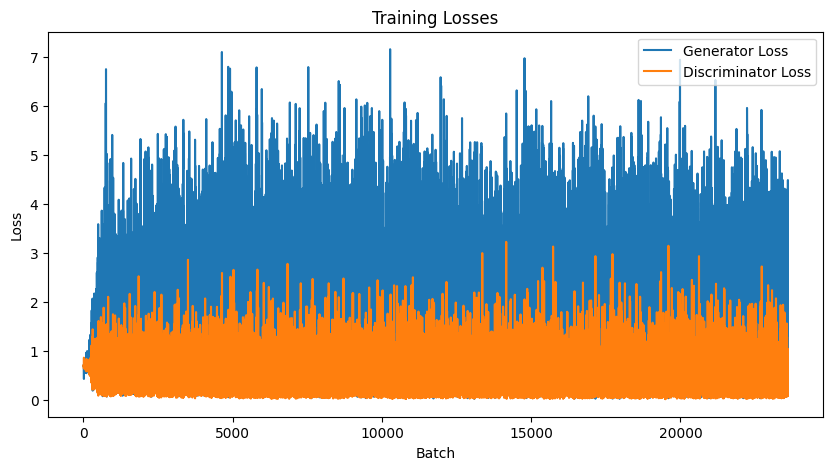

In [29]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# Define the Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.init_size = image_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + num_classes, 128 * self.init_size ** 2))

        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 3, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        label_input = self.label_emb(labels)
        gen_input = torch.cat((noise, label_input), -1)
        out = self.l1(gen_input)
        out = out.view(out.size(0), 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# Define the Discriminator
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.label_embedding = nn.Embedding(num_classes, num_classes)

        def discriminator_block(in_filters, out_filters, bn=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1),
                     nn.LeakyReLU(0.2, inplace=True),
                     nn.Dropout2d(0.25)]
            if bn:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(3 + num_classes, 16, bn=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = image_size // 2**4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size * ds_size, 1), nn.Sigmoid())

    def forward(self, img, labels):
        label_input = self.label_embedding(labels).view(labels.size(0), num_classes, 1, 1)
        label_input = label_input.repeat(1, 1, img.size(2), img.size(3))
        d_in = torch.cat((img, label_input), 1)
        out = self.model(d_in)
        out = out.view(out.size(0), -1)
        validity = self.adv_layer(out)
        return validity

# Initialize generator and discriminator
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Weight initialization
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0.0)

generator.apply(weights_init_normal)
discriminator.apply(weights_init_normal)

# Loss and optimizer
adversarial_loss = nn.BCELoss().to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=learning_rate, betas=(beta1, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta1, 0.999))

# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters in each model
print(f"Number of parameters in Generator: {count_parameters(generator)}")
print(f"Number of parameters in Discriminator: {count_parameters(discriminator)}")

# Initialize lists for storing losses
g_losses = []
d_losses = []

# Training function
def train(generator, discriminator, dataloader, num_epochs):
    global g_losses, d_losses  # Make the lists accessible inside the function
    start_time = time.time()
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}/{num_epochs}")
        for i, (imgs, labels) in enumerate(dataloader):
            batch_size = imgs.size(0)
            
            # Convert labels to match onion class indices
            labels = torch.tensor([class_to_idx[dataset.classes[label]] for label in labels]).to(device)
            if labels.max() >= num_classes:
                raise ValueError(f"  Label out of range: {labels.max()} (num_classes: {num_classes})")

            # Adversarial ground truths
            valid = torch.ones(batch_size, 1).to(device)
            fake = torch.zeros(batch_size, 1).to(device)

            # Configure input
            real_imgs = imgs.to(device)

            # ---------------------
            #  Train Generator
            # ---------------------

            optimizer_G.zero_grad()

            # Sample noise and labels as generator input
            z = torch.randn(batch_size, latent_dim).to(device)
            gen_labels = torch.randint(0, num_classes, (batch_size,)).to(device)
            
            # Generate a batch of images
            gen_imgs = generator(z, gen_labels)

            # Loss measures generator's ability to fool the discriminator
            validity = discriminator(gen_imgs, gen_labels)
            g_loss = adversarial_loss(validity, valid)

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            # Loss for real images
            validity_real = discriminator(real_imgs, labels)
            d_real_loss = adversarial_loss(validity_real, valid)

            # Loss for fake images
            validity_fake = discriminator(gen_imgs.detach(), gen_labels)
            d_fake_loss = adversarial_loss(validity_fake, fake)

            # Total discriminator loss
            d_loss = (d_real_loss + d_fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # Track losses
            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

    end_time = time.time()
    total_time = end_time - start_time
    print(f"Training completed in {total_time:.2f} seconds")

# Start training
try:
    train(generator, discriminator, dataloader, num_epochs)
except Exception as e:
    print(f"Error during training: {e}")

# Function to denormalize images
def denormalize(tensor):
    return tensor * 0.5 + 0.5  # Rescale to [0, 1]

# Function to generate and save images
# def generate_and_save_images(generator, num_images, output_dir, latent_dim, num_classes, image_size, class_names, device, batch_size=32):
#     # Ensure output directory exists
#     if not os.path.exists(output_dir):
#         os.makedirs(output_dir)
    
#     num_batches = (num_images + batch_size - 1) // batch_size

#     for batch in range(num_batches):
#         current_batch_size = min(batch_size, num_images - batch * batch_size)

#         # Generate images
#         z = torch.randn(current_batch_size, latent_dim, device=device)
#         gen_labels = torch.randint(0, num_classes, (current_batch_size,), device=device)
#         gen_imgs = generator(z, gen_labels).to(device)

#         # Denormalize images
#         gen_imgs = denormalize(gen_imgs)

#         # Save images in separate folders
#         for i in range(current_batch_size):
#             class_name = class_names[gen_labels[i].item()]
#             class_dir = os.path.join(output_dir, class_name)
#             if not os.path.exists(class_dir):
#                 os.makedirs(class_dir)
#             save_image(gen_imgs[i].cpu(), os.path.join(class_dir, f"{class_name}_{batch * batch_size + i}.png"))

# Plotting the losses
def plot_losses(g_losses, d_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(g_losses, label='Generator Loss')
    plt.plot(d_losses, label='Discriminator Loss')
    plt.title('Training Losses')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# After training
plot_losses(g_losses, d_losses)

In [34]:
def generate_and_save_images(generator, num_images, output_dir, latent_dim, num_classes, image_size, class_names):
    # Ensure output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    # Generate images
    z = torch.randn(num_images, latent_dim).to(device)
    gen_labels = torch.randint(0, num_classes, (num_images,)).to(device)
    gen_imgs = generator(z, gen_labels)
    
    # Denormalize images
    gen_imgs = denormalize(gen_imgs)
    
    # Save images in separate folders
    for i in range(num_images):
        class_name = class_names[gen_labels[i].item()]
        class_dir = os.path.join(output_dir, class_name)
        if not os.path.exists(class_dir):
            os.makedirs(class_dir)
        save_image(gen_imgs[i].to(device), os.path.join(class_dir, f"{class_name}_{i}.png"))

# Parameters
num_images_to_generate = 800
output_directory = '/raid/ee-mariyam/maryam/ayush/PlantVillage_gen_DCGAN_256'

# Generate and save images
generate_and_save_images(generator, num_images_to_generate, output_directory, latent_dim, num_classes, image_size, tomato_classes)

In [31]:
# Save the generator and discriminator models
torch.save(generator.state_dict(), '/raid/ee-mariyam/maryam/ayush/models/PlantVillage_DCGAN_256_generator.pth')
torch.save(discriminator.state_dict(), '/raid/ee-mariyam/maryam/ayush/models/PlantVillage_DCGAN_256_discriminator.pth')

In [32]:
device  = 'cpu'

In [33]:
# Create new instances of the Generator and Discriminator classes
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Load the saved state dicts into the models
generator.load_state_dict(torch.load('/raid/ee-mariyam/maryam/ayush/models/PlantVillage_DCGAN_256_generator.pth', map_location=torch.device('cpu')))
discriminator.load_state_dict(torch.load('/raid/ee-mariyam/maryam/ayush/models/PlantVillage_DCGAN_256_discriminator.pth'))

<All keys matched successfully>